In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter('ignore')


## Basic Sanity Check 
let's try to plot the mandelbrot set!

In [3]:
def calc(c, max_iter):
    z = 0
    i = 0
    while i < max_iter and np.abs(z) <= 2:
        z = z ** 2 + c
        i += 1          
    return i

In [4]:
max_iter = 50
resolution = 500
values = []
for a in np.linspace(-20, 10, resolution):
    for b in np.linspace(-10, 10, resolution):
        values.append([a, b, calc(complex(a/10, b/10), max_iter)])

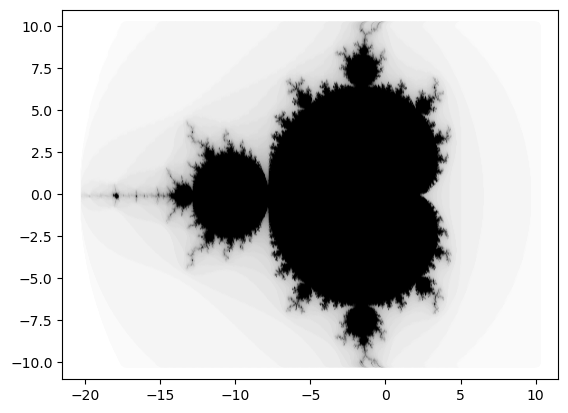

In [5]:
arr = np.array(values)

plt.scatter(x= arr[:, 0].astype('float'), y = arr[:, 1].astype('float'), c=max_iter - arr[:, 2], cmap='gray')
plt.show()

## Upgrading efficiency

### Introducing Derbail

The cumulative sum of the derivative of the mandelbrot set at the current iteration is defined as
${\displaystyle z_{n}^{\prime }:=(2*z_{n-1}^{\prime }*z_{n-1})+1}$


Convergence/Divergence is now decided by the Derivative Bailout (dbail) value, which should enhance detail with less computation


In [6]:
def mandelbrot(c: complex, max_iter: int):
    dbail = 1e6
    z, dz = 0, 1

    for i in range(max_iter):
        if abs(dz) > dbail:
            return i

        z = z * z + c
        dz = (2 * dz * z) + 1
    return i

In [7]:
def calculate_fractal(func, max_iter: int, dpi=150,
                 xmin=-2.5, xmax=1.5, ymin=-2, ymax=2,
                 WIDTH=1000, HEIGHT=1000, plot=True) -> np.ndarray:
    

    x = np.linspace(xmin, xmax, WIDTH)
    y = np.linspace(ymin, ymax, HEIGHT)

    # create cartesian plane
    X, Y = np.meshgrid(x, y)

    # make the plane complex
    Z = X + Y * 1j

    image = np.zeros((HEIGHT, WIDTH))

    # iterate over the plane
    for i in range(HEIGHT):
        for j in range(WIDTH):
            image[i, j] = func(Z[i, j], max_iter)

    if plot:
        plt.figure(dpi=dpi)
        plt.imshow(max(image.flatten())-image, cmap='gray',
                extent=(xmin, xmax, ymin, ymax), interpolation='bilinear')
        plt.axis('off')
        plt.show()

    return image


In [8]:
start = time.time()
calculate_fractal(mandelbrot, 30, plot=False)
print(f"{round(time.time() - start, 2)}s")

start = time.time()
calculate_fractal(calc, 30, plot=False)
print(f"{round(time.time() - start, 2)}s")

2.21s
5.14s


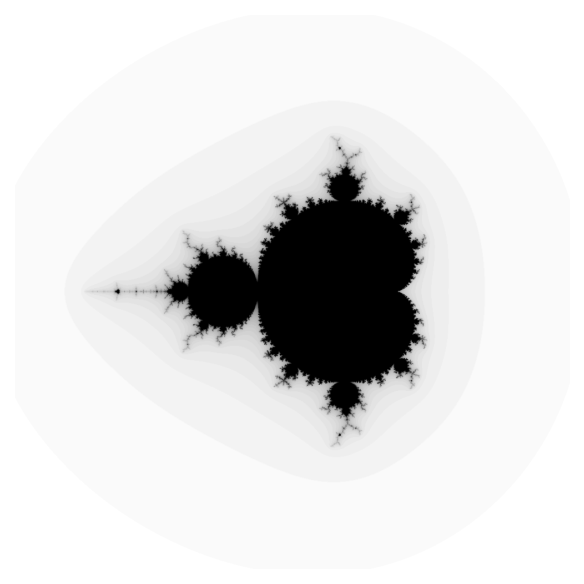

array([[4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])

In [9]:
calculate_fractal(mandelbrot, 50)

The results speak for themselves; derbail is much quicker at achieving similar results.


The next step is to replace "for" loops with matrix multiplication...

### Matrix Operations

In [43]:
def mandelbrot(Z, max_iter):
    z = np.zeros_like(Z)
    iters = np.zeros_like(Z)
    dz = np.ones_like(Z)
    dbail = 1e6

    for i in range(max_iter):
        mask = np.abs(dz) < dbail
        z[mask] = z[mask] * z[mask] + Z[mask]
        dz[mask] = 2 * dz[mask] * z[mask] + 1
        iters += mask
    
    return iters.astype('int')
    

In [51]:
def calculate_fractal(func, max_iter: int, dpi=150,
                      xmin=-2.5, xmax=1.5, ymin=-2, ymax=2,
                      WIDTH=1000, HEIGHT=1000, plot=True, cmap='binary') -> np.ndarray:

    x = np.linspace(xmin, xmax, WIDTH)
    y = np.linspace(ymin, ymax, HEIGHT)

    # create cartesian plane
    X, Y = np.meshgrid(x, y)

    # make the plane complex
    Z = X + Y * 1j

    image = func(Z, max_iter)
    
    if plot:
        plt.figure(dpi=dpi)
        plt.imshow(max(image.flatten())-image, cmap=cmap,
                   extent=(xmin, xmax, ymin, ymax), interpolation='bilinear')
        print(image.shape)
        plt.axis('off')
        plt.show()

    return image


In [58]:
start = time.time()
calculate_fractal(mandelbrot, 30, plot=False)
print(f"{round(time.time() - start, 2)}s")


0.31s


From 5 to .3 seconds - the improvement is drastic, and will make all the difference when rendering live.